In [342]:
import numpy as np
from hankel_dmd import *
from numerical_solvers_and_models import *
from scipy.interpolate import Rbf
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import stats
%matplotlib inline

def table_of_rbf_funs(shandle):
    dict_of_funs = {'multiquadric': lambda r,ep: np.sqrt((r/ep)**2. + 1.),
                    'inverse': lambda r,ep: 1.0/np.sqrt((r/ep)**2. + 1.),
                    'gaussian': lambda r,ep: np.exp(-(r/ep)**2.),
                    'linear': lambda r,ep: r,
                    'cubic': lambda r,ep: r**3.,
                    'quintic': lambda r,ep: r**5.,
                    'thin_plate': lambda r,ep: r**2. * np.ma.log(r)}
    return dict_of_funs[shandle]

def table_of_rbf_jac_funs(shandle):
    dict_of_funs = {'multiquadric': lambda r,ep: (r/ep**2.)/np.sqrt((r/ep)**2. + 1.),
                    'inverse': lambda r,ep: -(r/ep**2.)/((r/ep)**2. + 1.)**(1.5),
                    'gaussian': lambda r,ep: -2.*r/ep**2. * np.exp(-(r/ep)**2.),
                    'linear': lambda r,ep: 1.,
                    'cubic': lambda r,ep: 3.*r**2.,
                    'quintic': lambda r,ep: 5.*r**4.,
                    'thin_plate': lambda r,ep: r* (2.*np.ma.log(r)+1.)}
    return dict_of_funs[shandle]

def my_rbf_interpolator(ipts, fipts, qpt, shandle, jj):
    nfvls = np.shape(fipts)[0]
    xcoords = np.zeros((nfvls, 1), dtype=np.float64)
    ycoords = np.zeros((nfvls, 1), dtype=np.float64)
    zcoords = np.zeros((nfvls, 1), dtype=np.float64)
    vecxdir = np.zeros((1, nfvls), dtype=np.float64)
    vecydir = np.zeros((1, nfvls), dtype=np.float64)
    veczdir = np.zeros((1, nfvls), dtype=np.float64)

    myrbf = table_of_rbf_funs(shandle)
    jacmyrbf = table_of_rbf_jac_funs(shandle)

    xcoords[:,0] = ipts[:,0]
    ycoords[:,0] = ipts[:,1]
    zcoords[:,0] = ipts[:,2]
    difx = np.tile(xcoords.T,(nfvls,1)) - np.tile(xcoords,(1,nfvls))
    dify = np.tile(ycoords.T,(nfvls,1)) - np.tile(ycoords,(1,nfvls))
    difz = np.tile(zcoords.T,(nfvls,1)) - np.tile(zcoords,(1,nfvls))
    dist = np.sqrt(difx**2. + dify**2. + difz**2.)

    min_e = 400
    max_e = 500
    res = ipts[:,0].size
    testfunc = lambda x,y,z: np.sinc(x)*np.sinc(y)*np.sinc(z)
    rhs = testfunc(ipts[:,0], ipts[:,1], ipts[:,2])
    epval = np.linspace(min_e, max_e, res)
    
    if (jj/(NTT-1)*100) <= 1:
        phimat = [myrbf(dist,ep) for ep in epval]
        #phimat = np.asarray(phimat)
        #print(dist.shape)
        #print(phimat.shape)
        invphimat = [np.linalg.pinv(phi) for phi in phimat]
        error_func = [np.matmul(invphi, rhs)/np.diag(invphi) for invphi in invphimat]
        max_error = [np.linalg.norm(error, np.inf) for error in error_func]

        array = np.zeros(epval.size)
        for i in range(0,array.size):
            bool_e = max_error[i]==np.min(max_error)
            if bool_e == False:
                array[i] = 0
            else:
                array[i]=1
                loc = i


        print('Smallest maximum norm:', np.min(max_error))
        print('at epsilon = ', epval[loc])
    #     print(max_error)

        plt.figure()
        plt.plot(epval,np.log10(max_error))
        #plt.plot(epval,max_error)
        plt.show()

        minerr.append(np.min(max_error)) #here
        epsilon = int(epval[loc])
        ep_list.append(epsilon)
    else:
        e_list = np.asarray(ep_list)
        epsilon = stats.mode(e_list)
        print(epsilon)
        
    phimat = myrbf(dist, epsilon)
    cvals = np.linalg.solve(phimat,fipts)


    jacmat = np.zeros((3,3), dtype=np.float64)
    dqdxj = np.tile(np.reshape(qpt, (1,3)),(nfvls,1)) - ipts
    qdists = np.linalg.norm(dqdxj, axis=1)
    jacdists = jacmyrbf(qdists,epsilon)/qdists

    vecxdir[0,:] = cvals[:,0]*jacdists
    vecydir[0,:] = cvals[:,1]*jacdists
    veczdir[0,:] = cvals[:,2]*jacdists
    jacmat[0,:] = vecxdir @ dqdxj
    jacmat[1,:] = vecydir @ dqdxj
    jacmat[2,:] = veczdir @ dqdxj
    return jacmat

def jacobian_maker(reddata, indices, dt, jj):
    dstp = 1e-6

    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]
    fwdvls = reddata[:,np.mod(nnindices+np.ones(np.size(nnindices), dtype=int),NTT)]
    bwdvls = reddata[:,np.mod(nnindices-np.ones(np.size(nnindices), dtype=int),NTT)]
    fipts = (fwdvls - bwdvls)/(2.*dt)
#     print(ipts.shape)
    jacmat = my_rbf_interpolator(ipts.T, fipts.T, yloc+dstp*np.ones(3,dtype=np.float64), shandle, jj)
    return jacmat

In [343]:
import numpy as np
from hankel_dmd import *
from numerical_solvers_and_models import *
from scipy.interpolate import Rbf
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

sigma = 16.
bval = 4.
rval = 40.
dt = .01
t0 = 0.
tf = 120.
tvals = np.linspace(t0,tf,int((tf-t0)/dt)+1)
x0 = np.array([0., 1., 0.])
fhandle = lambda x: lorentz(x,sigma,rval,bval)
rawdata = timestepper(x0, t0, tf, dt, fhandle)

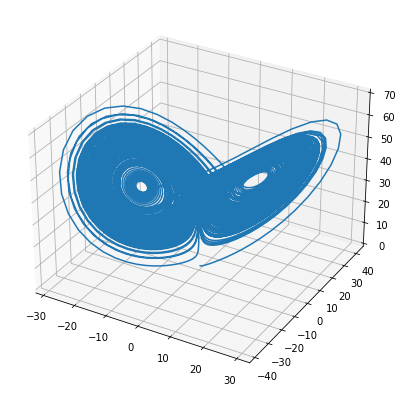

In [344]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot3D(rawdata[0,:], rawdata[1,:], rawdata[2,:])

In [345]:
transient_skp = 400
reddata = rawdata[:,transient_skp:]
print((reddata.T).shape)
nbrs = NearestNeighbors(n_neighbors=100, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)
ep_list = []
minerr=[]

(11601, 3)


Smallest maximum norm: 1.4996447405481327e-05
at epsilon =  400.0


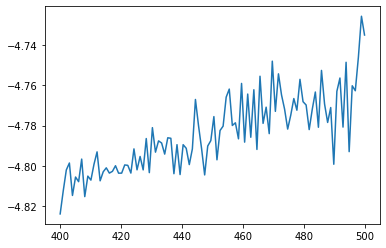

[[-16.08104664  16.02027783  -0.08773889]
 [ -2.54220076  -1.06765659  13.10471805]
 [-10.485128   -13.02694351  -3.90624264]] 




In [346]:
NTT = np.shape(reddata)[1]
shandle = 'gaussian'

for jj in range(10,11):
#     print(jj)

    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]

    jacmat = jacobian_maker(reddata, indices, dt, jj)
    print(jacmat,'\n\n')

Smallest maximum norm: 1.1570882920833978e-05
at epsilon =  467.67676767676767


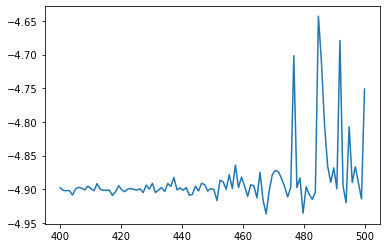

Smallest maximum norm: 2.7638000391849312e-05
at epsilon =  463.6363636363636


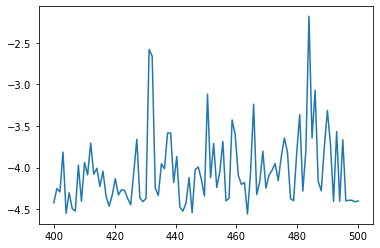

Smallest maximum norm: 2.7638000391849312e-05
at epsilon =  463.6363636363636


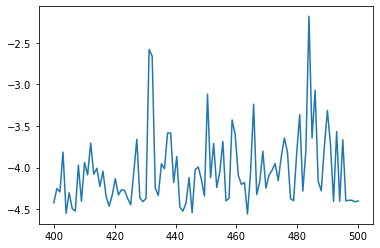

Smallest maximum norm: 4.666059075457098e-05
at epsilon =  454.54545454545456


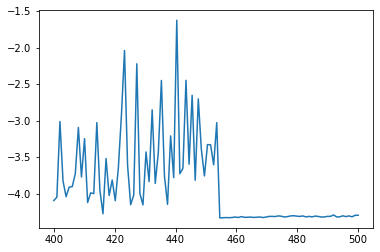

Smallest maximum norm: 4.666059075457098e-05
at epsilon =  454.54545454545456


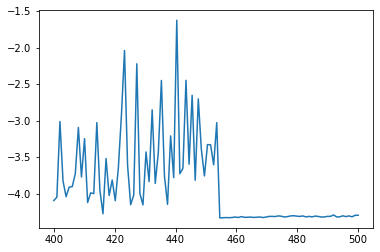

Smallest maximum norm: 7.030288829127565e-05
at epsilon =  492.92929292929296


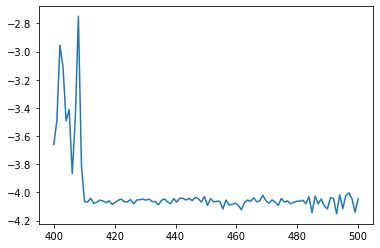

Smallest maximum norm: 7.030288829127565e-05
at epsilon =  492.92929292929296


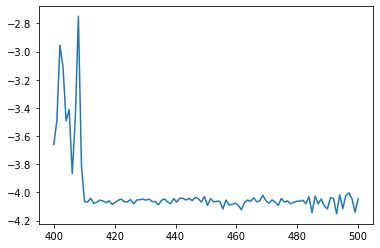

Smallest maximum norm: 3.045504541900768e-05
at epsilon =  494.949494949495


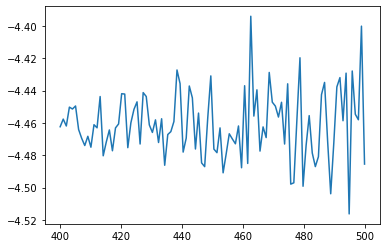

Smallest maximum norm: 3.045504541900768e-05
at epsilon =  494.949494949495


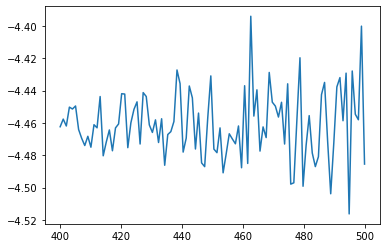

Smallest maximum norm: 6.218475519928364e-05
at epsilon =  481.8181818181818


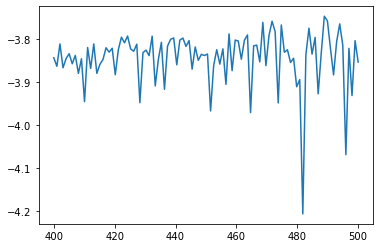

Smallest maximum norm: 6.218475519928364e-05
at epsilon =  481.8181818181818


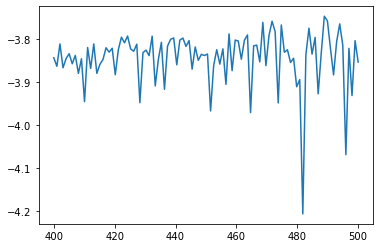

Smallest maximum norm: 6.088192628070407e-05
at epsilon =  486.8686868686869


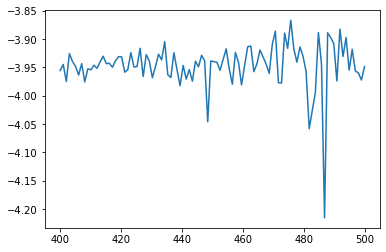

Smallest maximum norm: 6.088192628070407e-05
at epsilon =  486.8686868686869


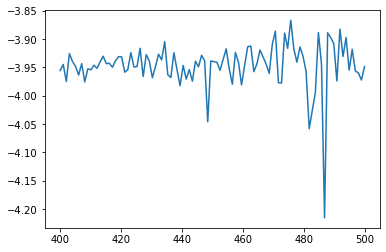

Smallest maximum norm: 7.843847558126046e-05
at epsilon =  477.77777777777777


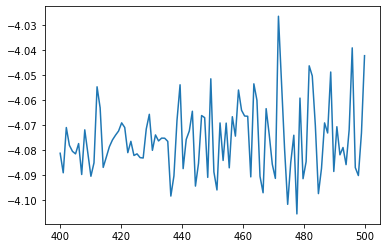

Smallest maximum norm: 7.843847558126046e-05
at epsilon =  477.77777777777777


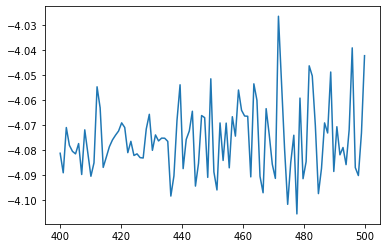

Smallest maximum norm: 3.485212199313767e-05
at epsilon =  488.8888888888889


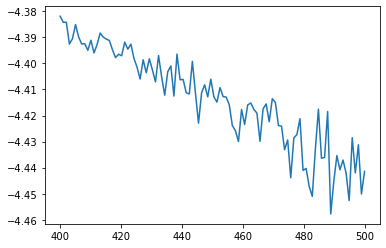

Smallest maximum norm: 3.485212199313767e-05
at epsilon =  488.8888888888889


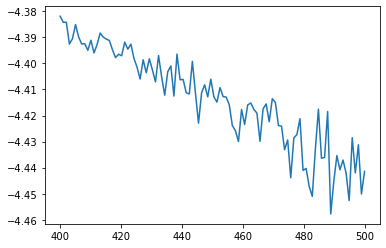

Smallest maximum norm: 6.352840620682959e-05
at epsilon =  404.04040404040404


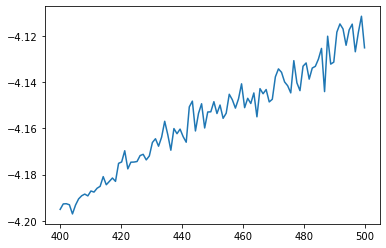

Smallest maximum norm: 6.352840620682959e-05
at epsilon =  404.04040404040404


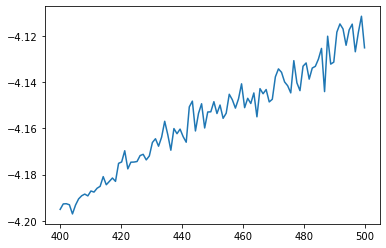

Smallest maximum norm: 1.4996447405481327e-05
at epsilon =  400.0


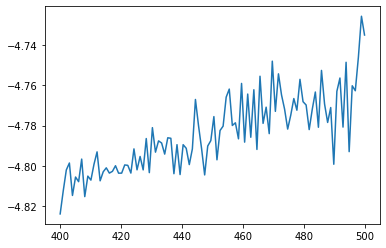

Smallest maximum norm: 1.4996447405481327e-05
at epsilon =  400.0


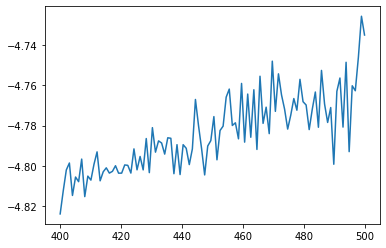

Smallest maximum norm: 2.7109224102236653e-05
at epsilon =  496.969696969697


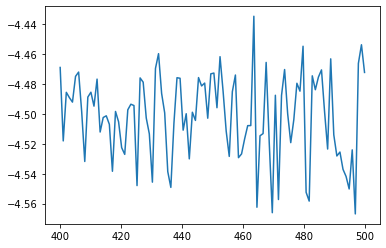

Smallest maximum norm: 2.7109224102236653e-05
at epsilon =  496.969696969697


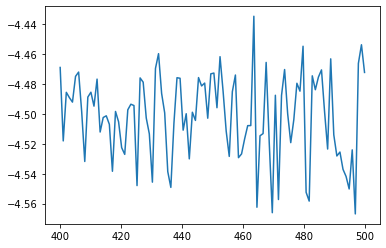

Smallest maximum norm: 0.00011644645656978009
at epsilon =  400.0


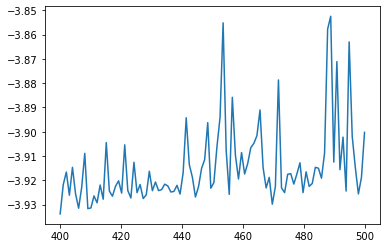

Smallest maximum norm: 0.00011644645656978009
at epsilon =  400.0


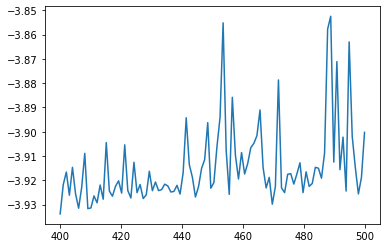

Smallest maximum norm: 0.00031143096385897643
at epsilon =  487.8787878787879


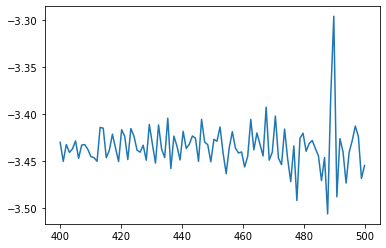

Smallest maximum norm: 0.00031143096385897643
at epsilon =  487.8787878787879


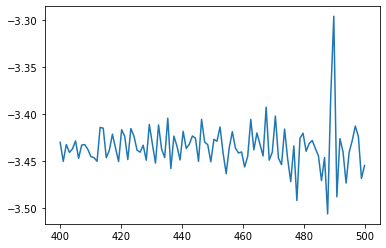

Smallest maximum norm: 0.00016248819397099705
at epsilon =  477.77777777777777


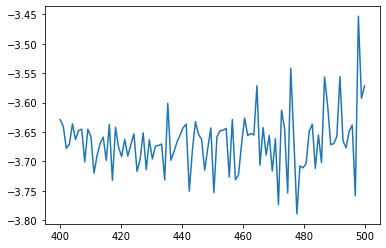

Smallest maximum norm: 0.00016248819397099705
at epsilon =  477.77777777777777


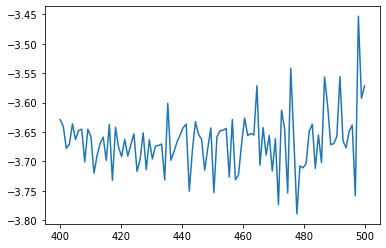

Smallest maximum norm: 0.0004613567790634588
at epsilon =  448.4848484848485


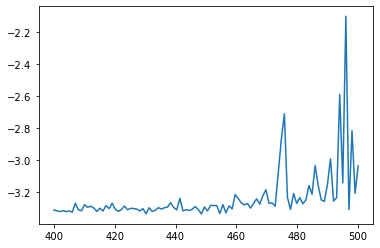

Smallest maximum norm: 0.0004613567790634588
at epsilon =  448.4848484848485


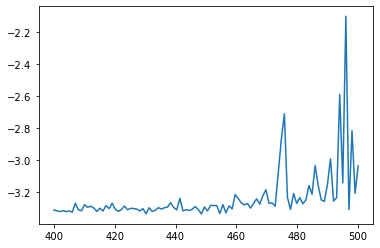

Smallest maximum norm: 0.0002464326053607715
at epsilon =  498.98989898989896


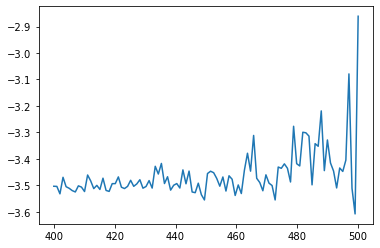

Smallest maximum norm: 0.0002464326053607715
at epsilon =  498.98989898989896


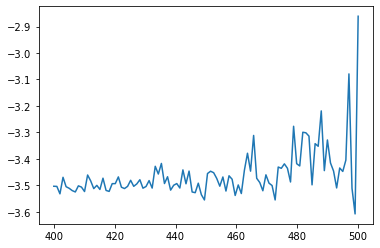

Smallest maximum norm: 0.00013756574856401785
at epsilon =  412.1212121212121


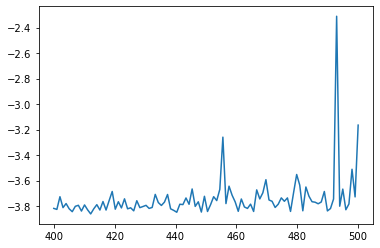

Smallest maximum norm: 0.00013756574856401785
at epsilon =  412.1212121212121


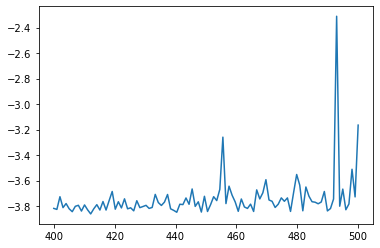

Smallest maximum norm: 9.94501281850713e-05
at epsilon =  463.6363636363636


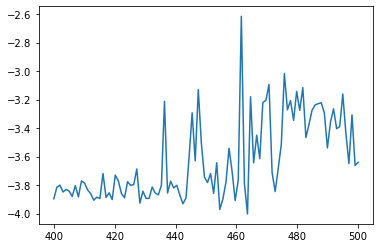

Smallest maximum norm: 9.94501281850713e-05
at epsilon =  463.6363636363636


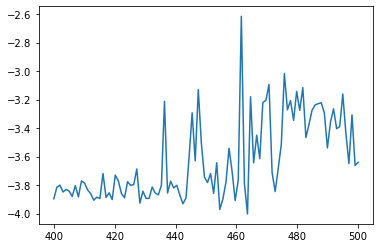

Smallest maximum norm: 0.00013206517636182253
at epsilon =  451.5151515151515


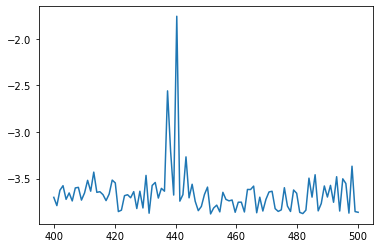

Smallest maximum norm: 0.00013206517636182253
at epsilon =  451.5151515151515


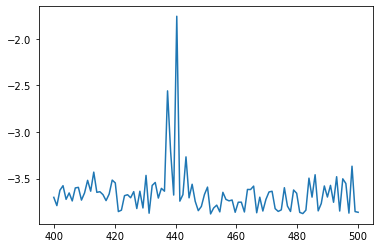

Smallest maximum norm: 3.481319954921088e-05
at epsilon =  456.5656565656566


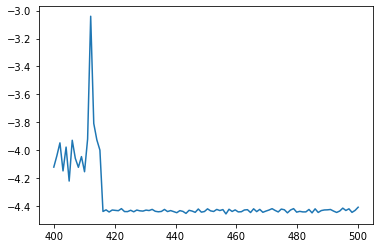

Smallest maximum norm: 3.481319954921088e-05
at epsilon =  456.5656565656566


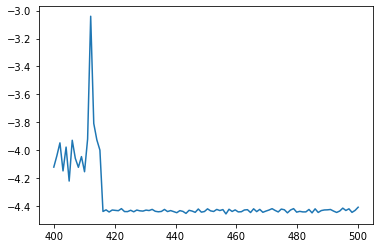

Smallest maximum norm: 5.6709988206047844e-05
at epsilon =  476.7676767676768


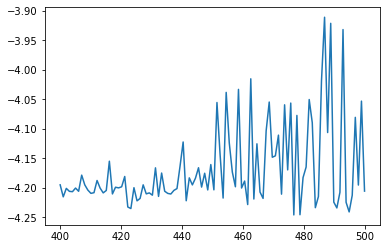

Smallest maximum norm: 5.6709988206047844e-05
at epsilon =  476.7676767676768


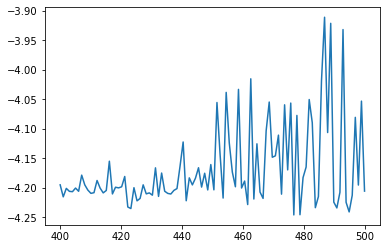

Smallest maximum norm: 5.5998012045484884e-05
at epsilon =  451.5151515151515


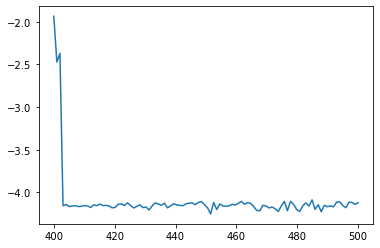

Smallest maximum norm: 5.5998012045484884e-05
at epsilon =  451.5151515151515


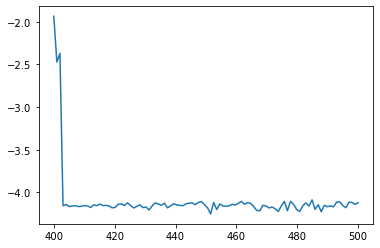

Smallest maximum norm: 0.00025708585482321297
at epsilon =  490.90909090909093


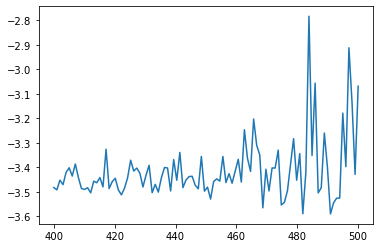

Smallest maximum norm: 0.00025708585482321297
at epsilon =  490.90909090909093


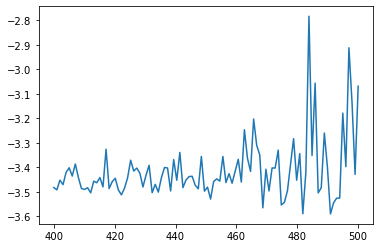

Smallest maximum norm: 0.00020496777454354052
at epsilon =  489.8989898989899


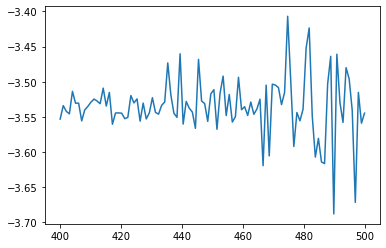

Smallest maximum norm: 0.00020496777454354052
at epsilon =  489.8989898989899


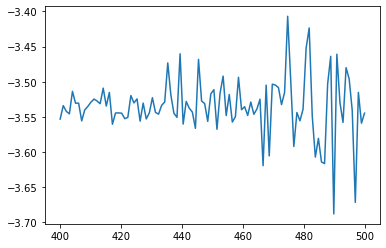

Smallest maximum norm: 0.00010583891192323847
at epsilon =  488.8888888888889


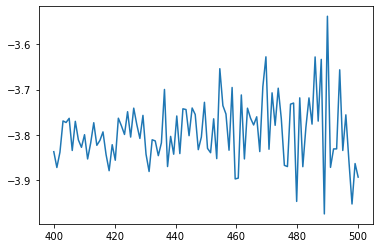

Smallest maximum norm: 0.00010583891192323847
at epsilon =  488.8888888888889


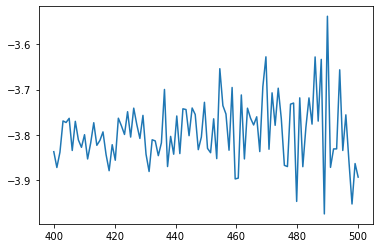

Smallest maximum norm: 5.9275667676394354e-05
at epsilon =  493.93939393939394


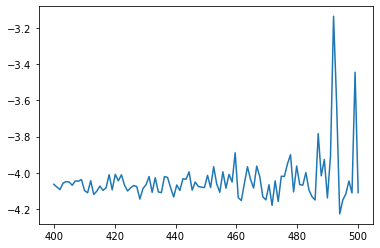

Smallest maximum norm: 5.9275667676394354e-05
at epsilon =  493.93939393939394


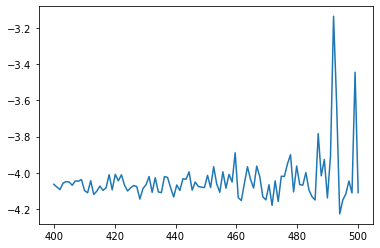

Smallest maximum norm: 9.45482177068862e-05
at epsilon =  444.44444444444446


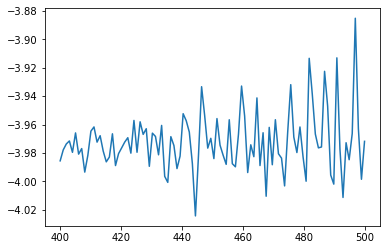

Smallest maximum norm: 9.45482177068862e-05
at epsilon =  444.44444444444446


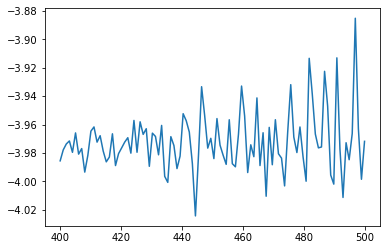

Smallest maximum norm: 0.00010529481271107855
at epsilon =  458.5858585858586


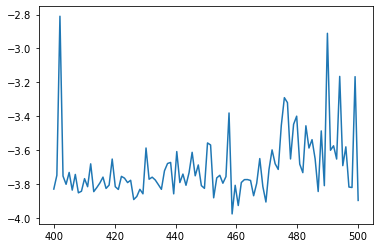

Smallest maximum norm: 0.00010529481271107855
at epsilon =  458.5858585858586


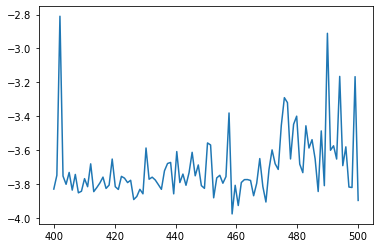

Smallest maximum norm: 6.993324899066977e-05
at epsilon =  490.90909090909093


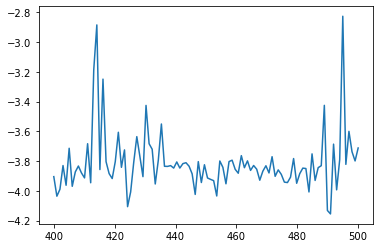

Smallest maximum norm: 6.993324899066977e-05
at epsilon =  490.90909090909093


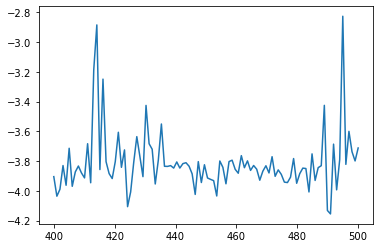

Smallest maximum norm: 2.117943402570313e-05
at epsilon =  414.14141414141415


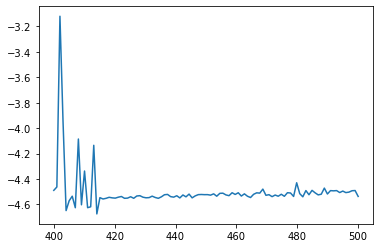

Smallest maximum norm: 2.117943402570313e-05
at epsilon =  414.14141414141415


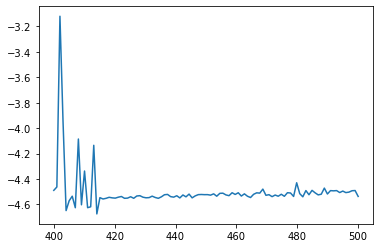

Smallest maximum norm: 4.676000034776517e-05
at epsilon =  441.4141414141414


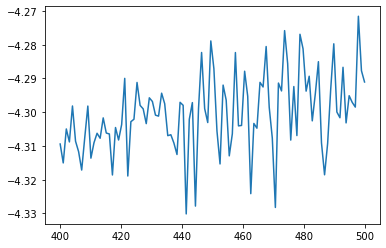

Smallest maximum norm: 4.676000034776517e-05
at epsilon =  441.4141414141414


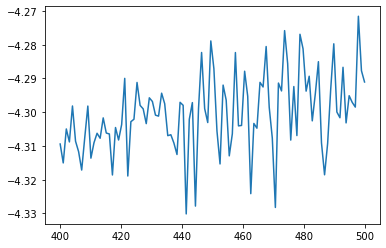

Smallest maximum norm: 2.1479641623409865e-05
at epsilon =  474.74747474747477


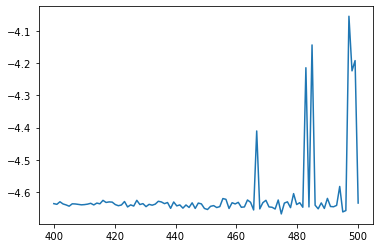

Smallest maximum norm: 2.1479641623409865e-05
at epsilon =  474.74747474747477


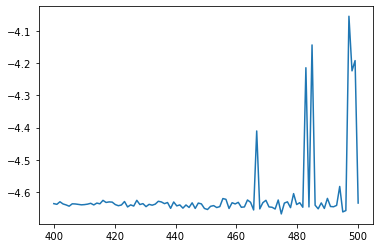

Smallest maximum norm: 2.3090166401886046e-05
at epsilon =  498.98989898989896


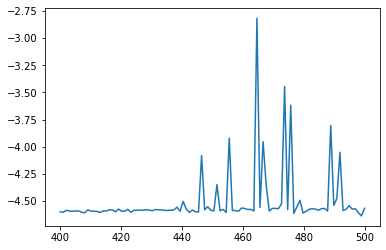

Smallest maximum norm: 2.3090166401886046e-05
at epsilon =  498.98989898989896


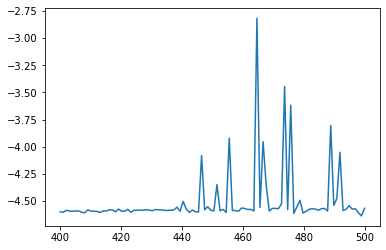

Smallest maximum norm: 6.641985629110198e-05
at epsilon =  495.95959595959596


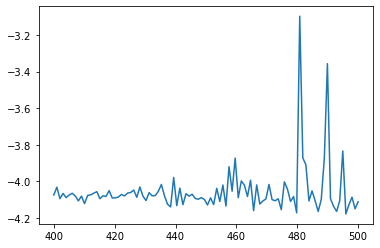

Smallest maximum norm: 6.641985629110198e-05
at epsilon =  495.95959595959596


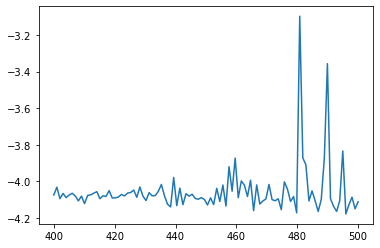

Smallest maximum norm: 2.1508801104170842e-05
at epsilon =  440.4040404040404


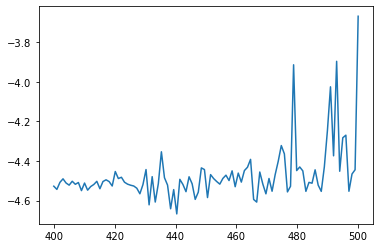

Smallest maximum norm: 2.1508801104170842e-05
at epsilon =  440.4040404040404


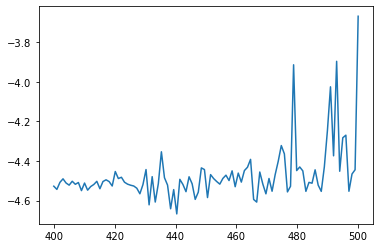

Smallest maximum norm: 1.859155815680451e-05
at epsilon =  494.949494949495


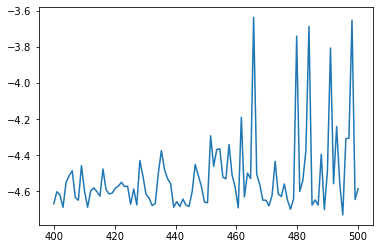

Smallest maximum norm: 1.859155815680451e-05
at epsilon =  494.949494949495


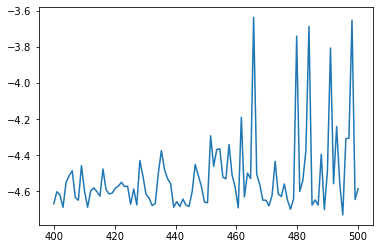

Smallest maximum norm: 4.2086693565201544e-05
at epsilon =  419.19191919191917


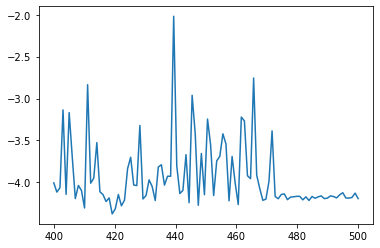

Smallest maximum norm: 4.2086693565201544e-05
at epsilon =  419.19191919191917


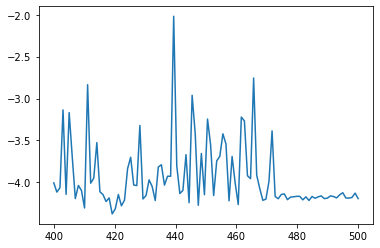

Smallest maximum norm: 3.375441158106458e-05
at epsilon =  423.2323232323232


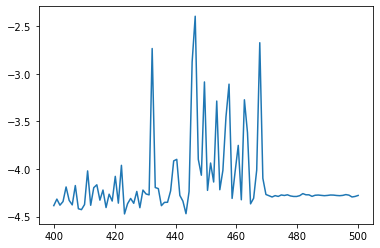

Smallest maximum norm: 3.375441158106458e-05
at epsilon =  423.2323232323232


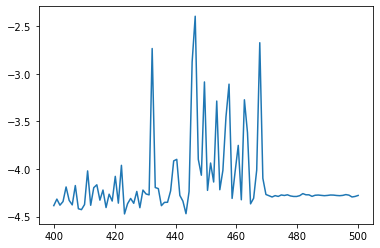

Smallest maximum norm: 2.520002333210053e-05
at epsilon =  487.8787878787879


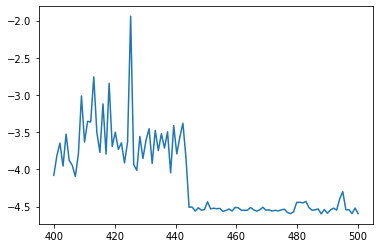

Smallest maximum norm: 2.520002333210053e-05
at epsilon =  487.8787878787879


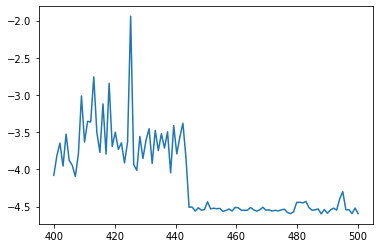

Smallest maximum norm: 3.382732463953161e-05
at epsilon =  490.90909090909093


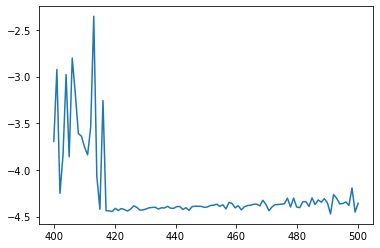

Smallest maximum norm: 3.382732463953161e-05
at epsilon =  490.90909090909093


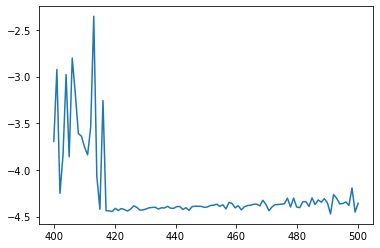

Smallest maximum norm: 1.469256575222033e-05
at epsilon =  492.92929292929296


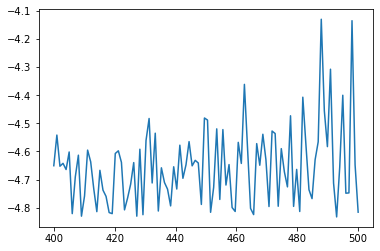

Smallest maximum norm: 1.469256575222033e-05
at epsilon =  492.92929292929296


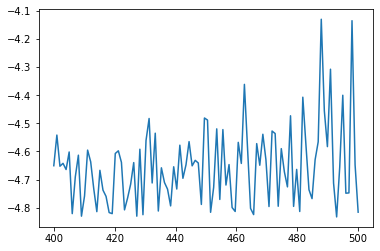

Smallest maximum norm: 2.5865923179430725e-05
at epsilon =  449.4949494949495


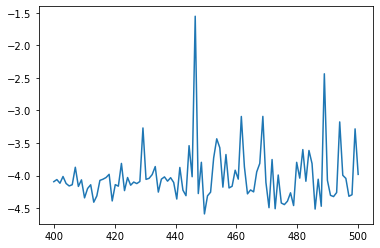

Smallest maximum norm: 2.5865923179430725e-05
at epsilon =  449.4949494949495


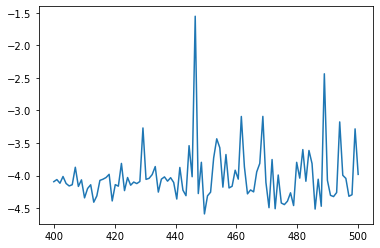

Smallest maximum norm: 1.50043624231447e-05
at epsilon =  400.0


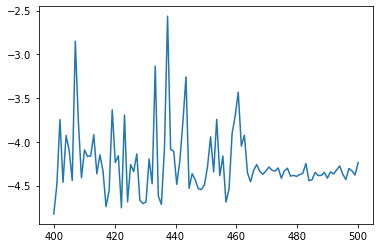

Smallest maximum norm: 1.50043624231447e-05
at epsilon =  400.0


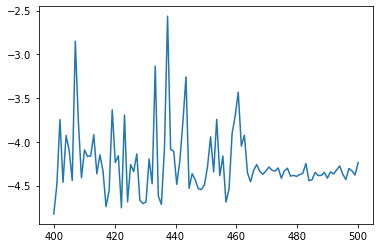

Smallest maximum norm: 3.484554607934411e-05
at epsilon =  402.020202020202


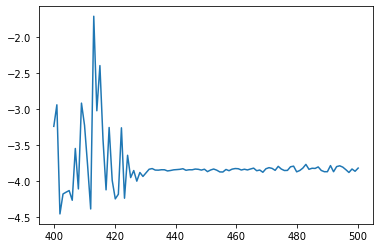

Smallest maximum norm: 3.484554607934411e-05
at epsilon =  402.020202020202


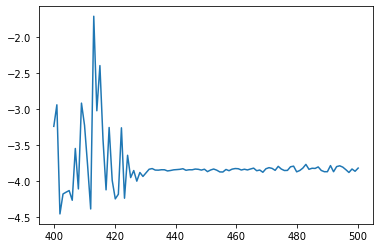

Smallest maximum norm: 0.0001393943741691336
at epsilon =  497.979797979798


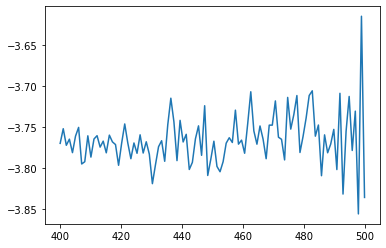

Smallest maximum norm: 0.0001393943741691336
at epsilon =  497.979797979798


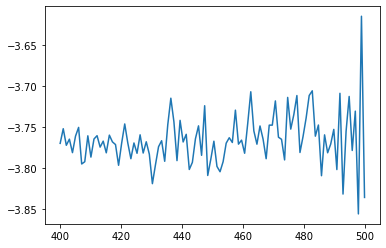

Smallest maximum norm: 0.00011478348489270257
at epsilon =  481.8181818181818


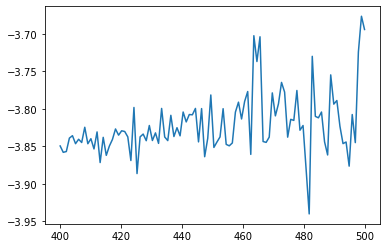

Smallest maximum norm: 0.00011478348489270257
at epsilon =  481.8181818181818


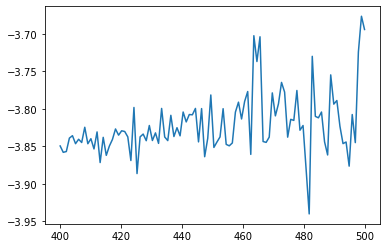

Smallest maximum norm: 5.4725767193679064e-05
at epsilon =  421.2121212121212


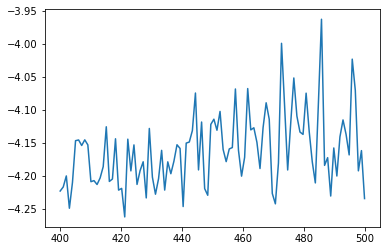

Smallest maximum norm: 5.4725767193679064e-05
at epsilon =  421.2121212121212


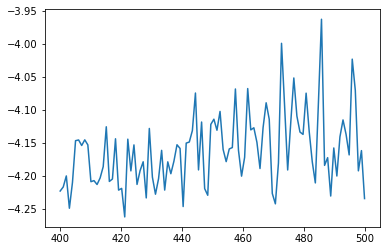

Smallest maximum norm: 7.053271748453124e-05
at epsilon =  491.9191919191919


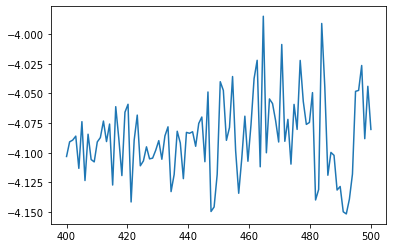

Smallest maximum norm: 7.053271748453124e-05
at epsilon =  491.9191919191919


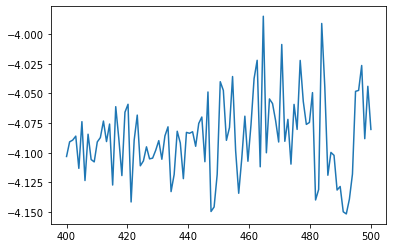

Smallest maximum norm: 9.983573508280075e-05
at epsilon =  468.6868686868687


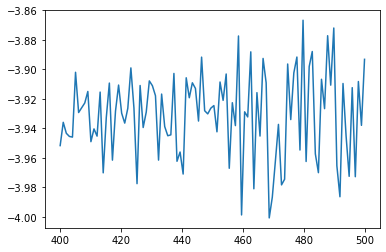

Smallest maximum norm: 9.983573508280075e-05
at epsilon =  468.6868686868687


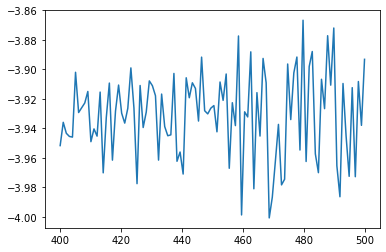

Smallest maximum norm: 7.760995953096755e-05
at epsilon =  467.67676767676767


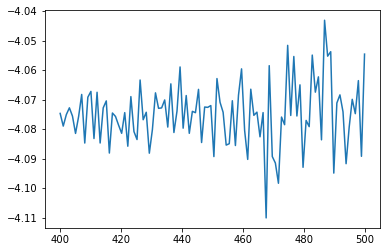

Smallest maximum norm: 7.760995953096755e-05
at epsilon =  467.67676767676767


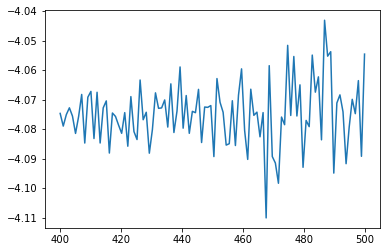

Smallest maximum norm: 3.935481424289107e-06
at epsilon =  497.979797979798


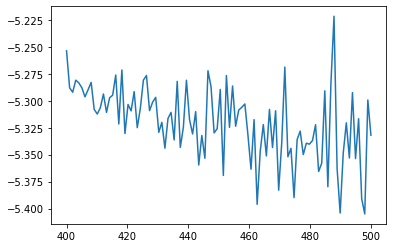

Smallest maximum norm: 3.935481424289107e-06
at epsilon =  497.979797979798


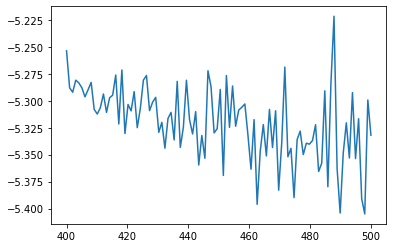

Smallest maximum norm: 3.2296628602546464e-05
at epsilon =  417.17171717171715


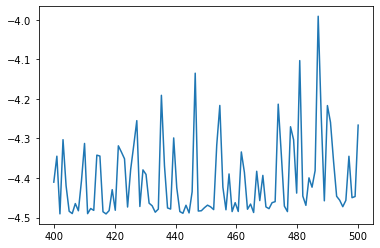

Smallest maximum norm: 3.2296628602546464e-05
at epsilon =  417.17171717171715


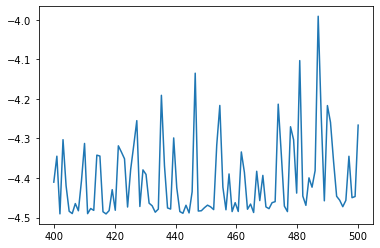

Smallest maximum norm: 6.935840563858697e-05
at epsilon =  489.8989898989899


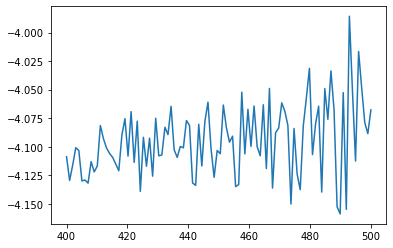

Smallest maximum norm: 6.935840563858697e-05
at epsilon =  489.8989898989899


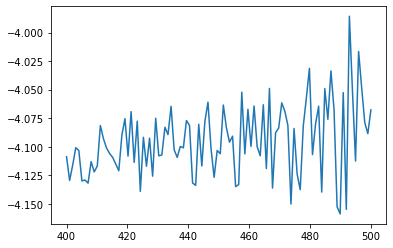

Smallest maximum norm: 2.772503491065258e-05
at epsilon =  485.85858585858585


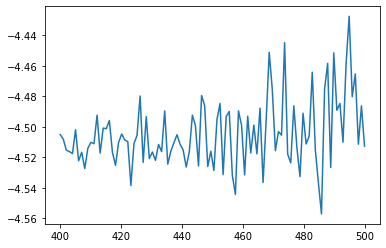

Smallest maximum norm: 2.772503491065258e-05
at epsilon =  485.85858585858585


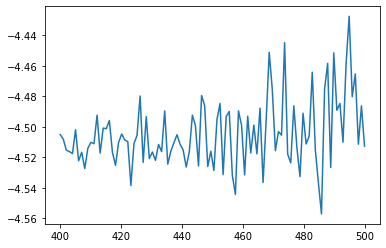

Smallest maximum norm: 0.00014470876873858493
at epsilon =  489.8989898989899


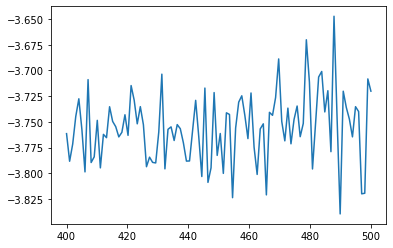

Smallest maximum norm: 0.00014470876873858493
at epsilon =  489.8989898989899


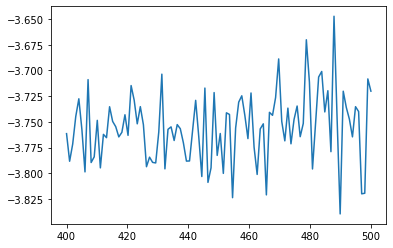

Smallest maximum norm: 0.00012579536585827545
at epsilon =  464.64646464646466


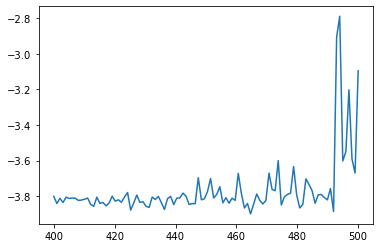

Smallest maximum norm: 0.00012579536585827545
at epsilon =  464.64646464646466


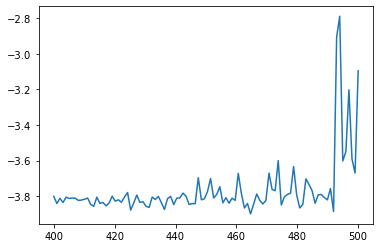

Smallest maximum norm: 0.00025100877381686155
at epsilon =  456.5656565656566


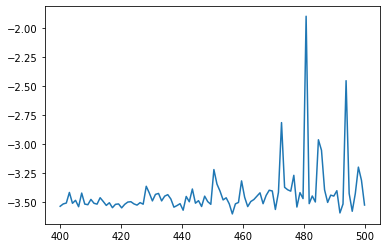

Smallest maximum norm: 0.00025100877381686155
at epsilon =  456.5656565656566


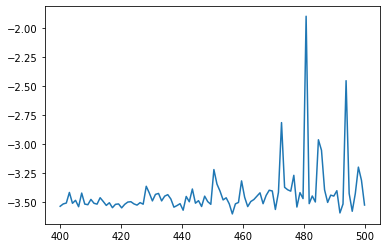

Smallest maximum norm: 0.00017623307048827454
at epsilon =  462.62626262626264


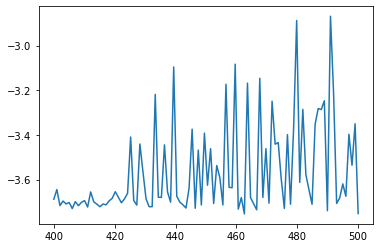

Smallest maximum norm: 0.00017623307048827454
at epsilon =  462.62626262626264


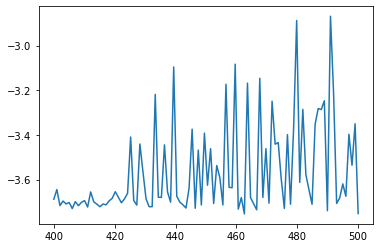

Smallest maximum norm: 0.00010697662897263125
at epsilon =  472.72727272727275


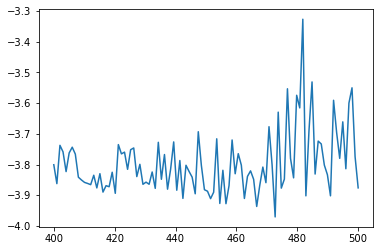

Smallest maximum norm: 0.00010697662897263125
at epsilon =  472.72727272727275


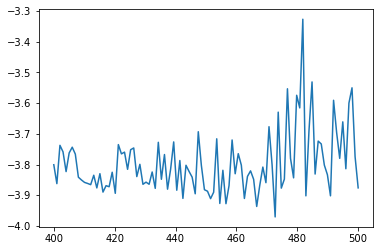

Smallest maximum norm: 4.204652715218366e-05
at epsilon =  407.07070707070704


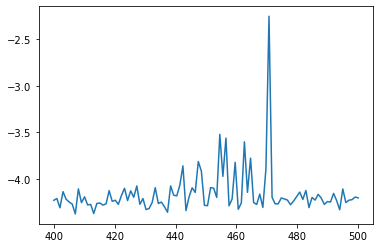

Smallest maximum norm: 4.204652715218366e-05
at epsilon =  407.07070707070704


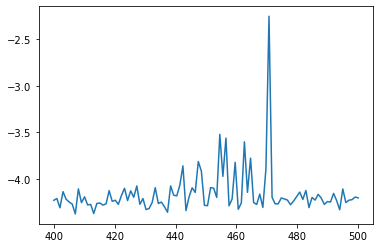

Smallest maximum norm: 7.224136771249519e-05
at epsilon =  403.030303030303


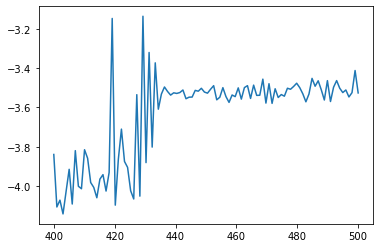

Smallest maximum norm: 7.224136771249519e-05
at epsilon =  403.030303030303


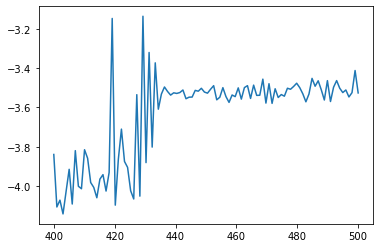

Smallest maximum norm: 6.810196412282642e-05
at epsilon =  400.0


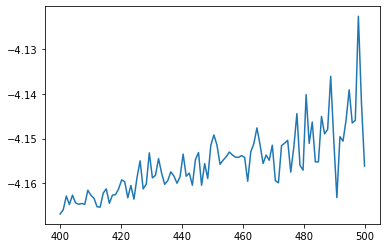

Smallest maximum norm: 6.810196412282642e-05
at epsilon =  400.0


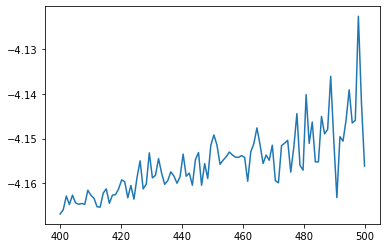

Smallest maximum norm: 0.00014759148330608575
at epsilon =  497.979797979798


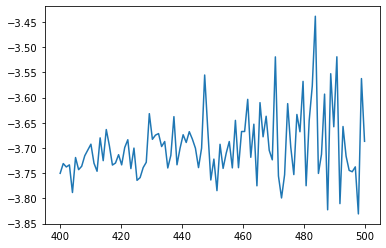

Smallest maximum norm: 0.00014759148330608575
at epsilon =  497.979797979798


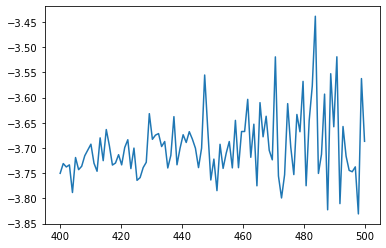

Smallest maximum norm: 0.00026279773250788383
at epsilon =  486.8686868686869


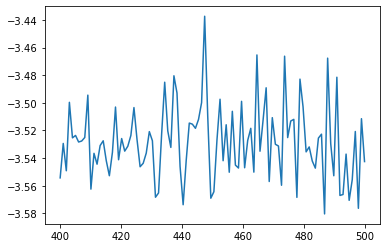

Smallest maximum norm: 0.00026279773250788383
at epsilon =  486.8686868686869


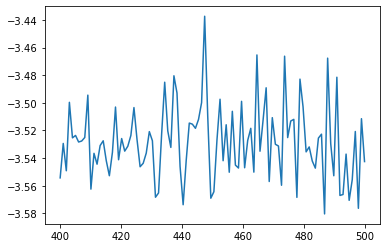

Smallest maximum norm: 0.00017264351767389135
at epsilon =  487.8787878787879


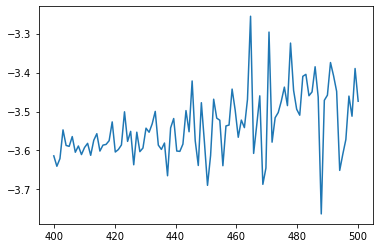

Smallest maximum norm: 0.00017264351767389135
at epsilon =  487.8787878787879


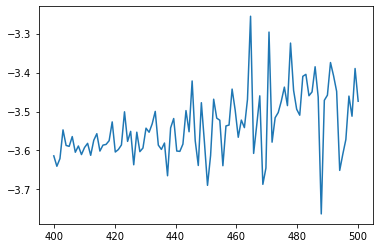

Smallest maximum norm: 7.630684724462043e-05
at epsilon =  488.8888888888889


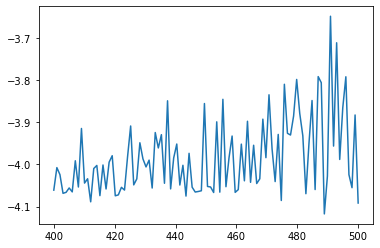

Smallest maximum norm: 7.630684724462043e-05
at epsilon =  488.8888888888889


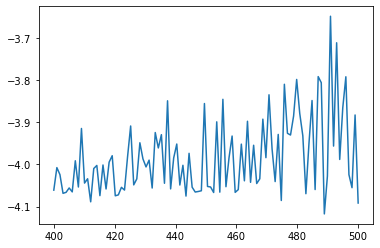

Smallest maximum norm: 0.0001247417400590815
at epsilon =  490.90909090909093


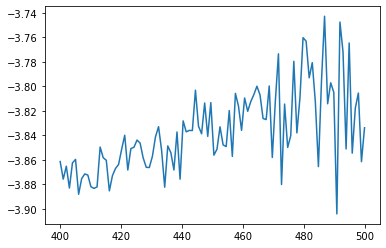

Smallest maximum norm: 0.0001247417400590815
at epsilon =  490.90909090909093


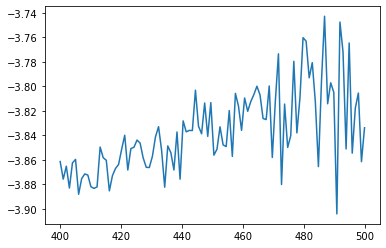

Smallest maximum norm: 4.6332699508309074e-05
at epsilon =  486.8686868686869


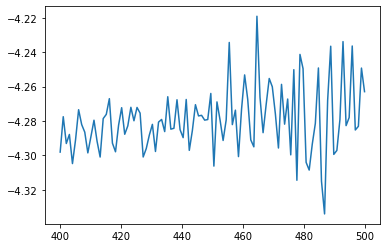

Smallest maximum norm: 4.6332699508309074e-05
at epsilon =  486.8686868686869


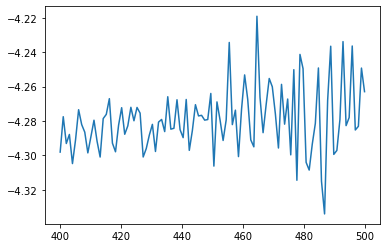

Smallest maximum norm: 4.644892776380174e-05
at epsilon =  495.95959595959596


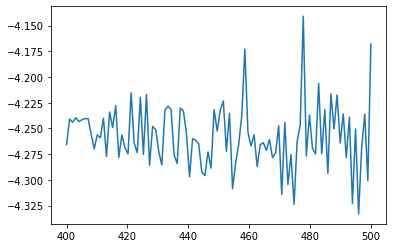

Smallest maximum norm: 4.644892776380174e-05
at epsilon =  495.95959595959596


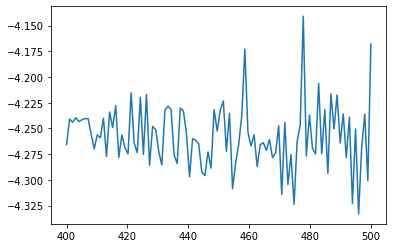

Smallest maximum norm: 2.4193631988663476e-05
at epsilon =  491.9191919191919


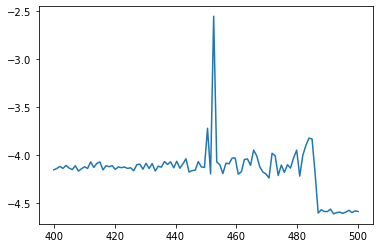

Smallest maximum norm: 2.4193631988663476e-05
at epsilon =  491.9191919191919


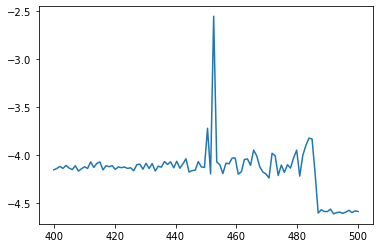

Smallest maximum norm: 3.011431448181751e-05
at epsilon =  489.8989898989899


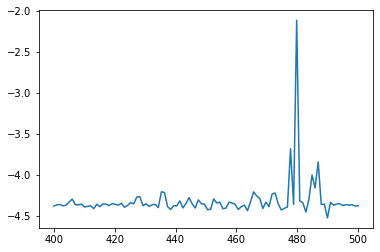

Smallest maximum norm: 3.011431448181751e-05
at epsilon =  489.8989898989899


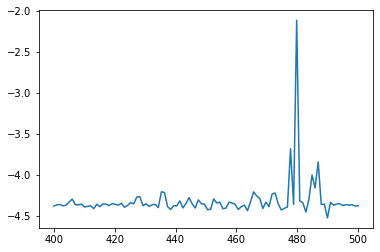

Smallest maximum norm: 1.8313388651043225e-05
at epsilon =  417.17171717171715


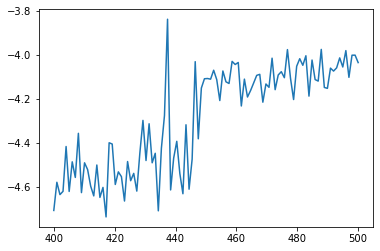

Smallest maximum norm: 1.8313388651043225e-05
at epsilon =  417.17171717171715


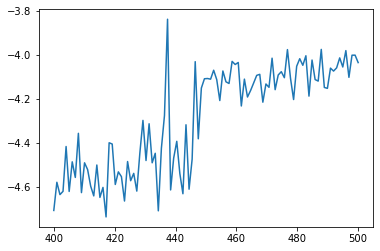

Smallest maximum norm: 1.822852596742863e-05
at epsilon =  411.1111111111111


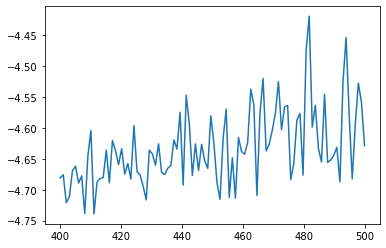

Smallest maximum norm: 1.822852596742863e-05
at epsilon =  411.1111111111111


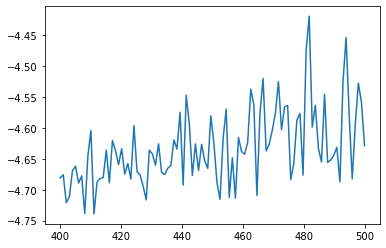

Smallest maximum norm: 2.9845060063023175e-05
at epsilon =  484.8484848484849


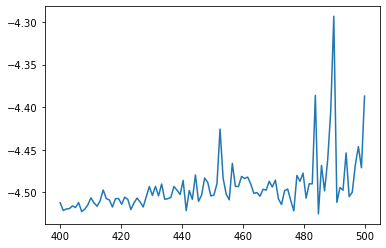

Smallest maximum norm: 2.9845060063023175e-05
at epsilon =  484.8484848484849


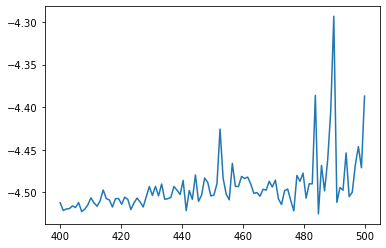

Smallest maximum norm: 2.655574220642129e-05
at epsilon =  493.93939393939394


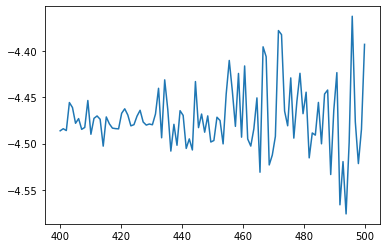

Smallest maximum norm: 2.655574220642129e-05
at epsilon =  493.93939393939394


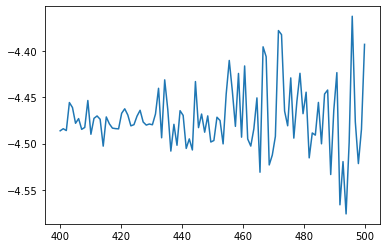

Smallest maximum norm: 2.962518598680049e-05
at epsilon =  490.90909090909093


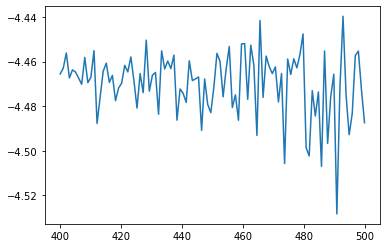

Smallest maximum norm: 2.962518598680049e-05
at epsilon =  490.90909090909093


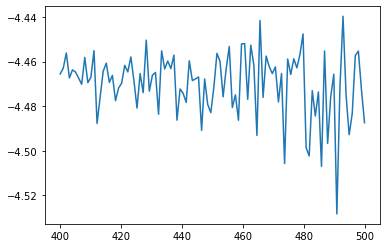

Smallest maximum norm: 5.050614495126602e-05
at epsilon =  494.949494949495


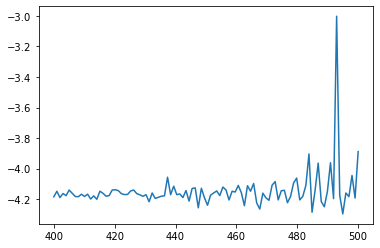

Smallest maximum norm: 5.050614495126602e-05
at epsilon =  494.949494949495


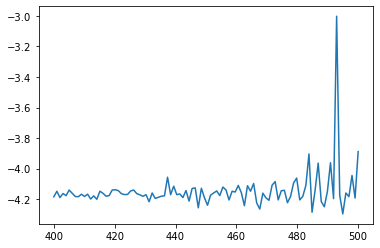

Smallest maximum norm: 2.1776444302627258e-05
at epsilon =  500.0


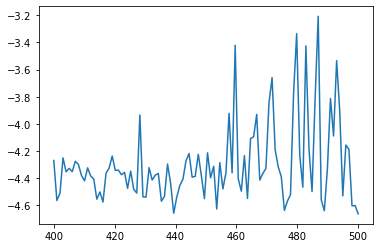

Smallest maximum norm: 2.1776444302627258e-05
at epsilon =  500.0


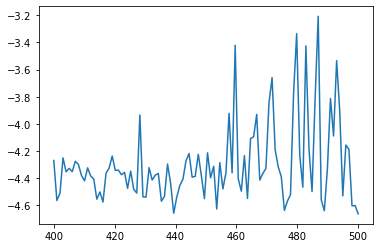

Smallest maximum norm: 6.488942357519488e-05
at epsilon =  444.44444444444446


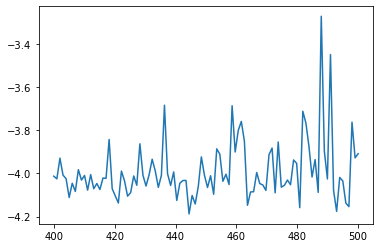

Smallest maximum norm: 6.488942357519488e-05
at epsilon =  444.44444444444446


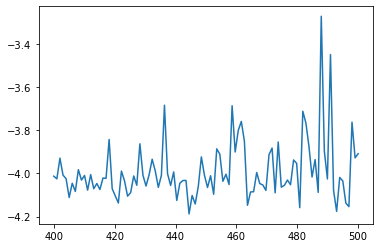

Smallest maximum norm: 5.0245005636235156e-05
at epsilon =  498.98989898989896


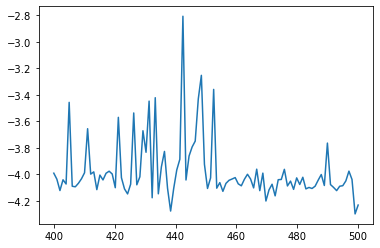

Smallest maximum norm: 5.0245005636235156e-05
at epsilon =  498.98989898989896


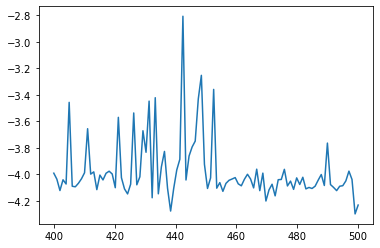

Smallest maximum norm: 2.1700957326761096e-05
at epsilon =  454.54545454545456


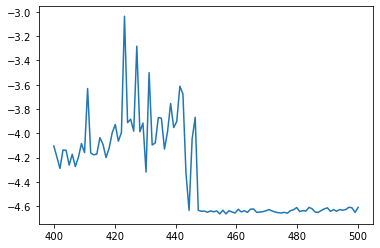

Smallest maximum norm: 2.1700957326761096e-05
at epsilon =  454.54545454545456


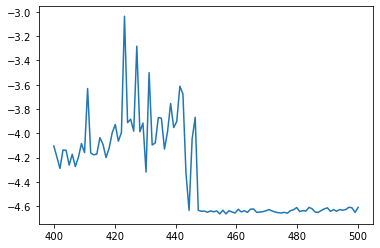

Smallest maximum norm: 2.3910237558493164e-05
at epsilon =  418.1818181818182


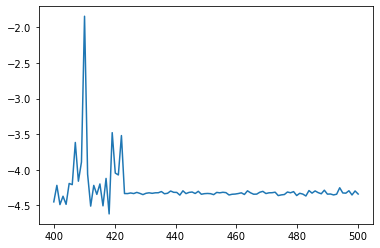

Smallest maximum norm: 2.3910237558493164e-05
at epsilon =  418.1818181818182


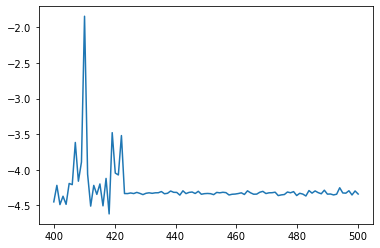

Smallest maximum norm: 1.6141535376158452e-05
at epsilon =  402.020202020202


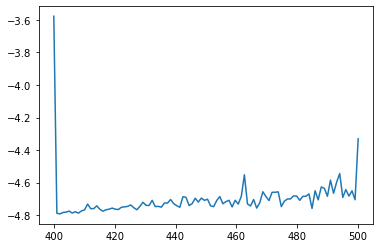

Smallest maximum norm: 1.6141535376158452e-05
at epsilon =  402.020202020202


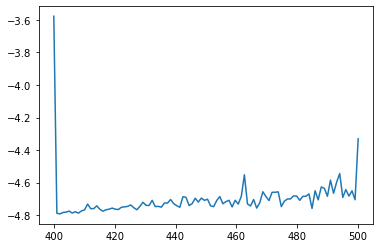

Smallest maximum norm: 2.4473531729751627e-05
at epsilon =  458.5858585858586


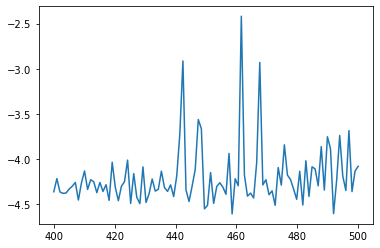

Smallest maximum norm: 2.4473531729751627e-05
at epsilon =  458.5858585858586


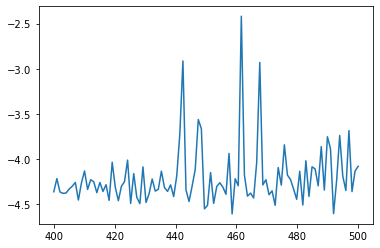

Smallest maximum norm: 2.10844730376216e-05
at epsilon =  492.92929292929296


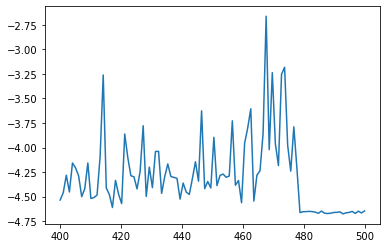

Smallest maximum norm: 2.10844730376216e-05
at epsilon =  492.92929292929296


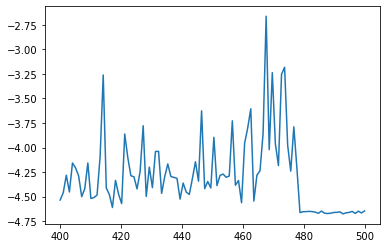

Smallest maximum norm: 2.2064938130281338e-05
at epsilon =  428.2828282828283


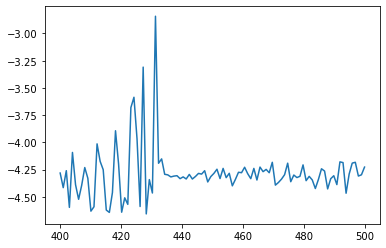

Smallest maximum norm: 2.2064938130281338e-05
at epsilon =  428.2828282828283


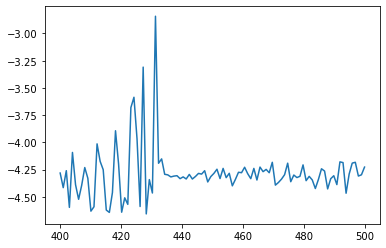

Smallest maximum norm: 2.2167782211629168e-05
at epsilon =  417.17171717171715


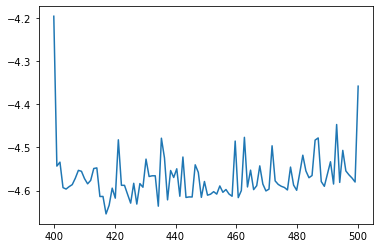

Smallest maximum norm: 2.2167782211629168e-05
at epsilon =  417.17171717171715


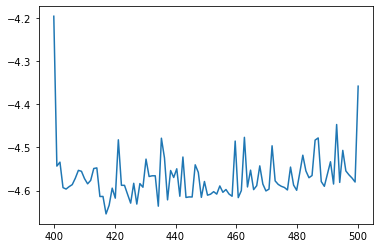

Smallest maximum norm: 3.8272388035159474e-05
at epsilon =  400.0


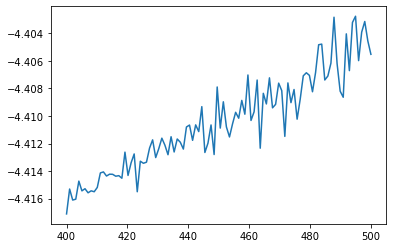

Smallest maximum norm: 3.8272388035159474e-05
at epsilon =  400.0


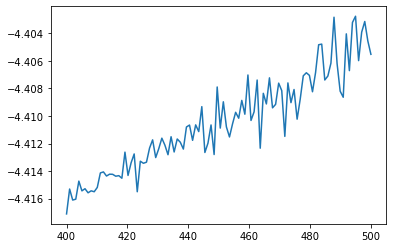

Smallest maximum norm: 5.6315568091639985e-05
at epsilon =  495.95959595959596


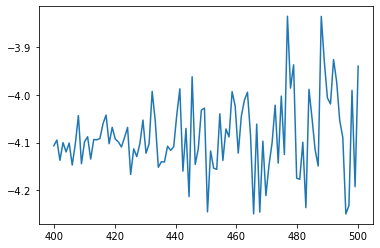

Smallest maximum norm: 5.6315568091639985e-05
at epsilon =  495.95959595959596


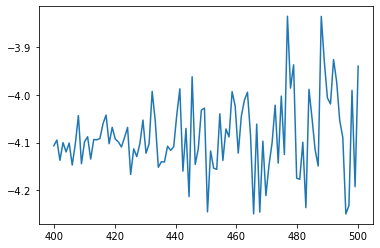

Smallest maximum norm: 3.734868583000542e-05
at epsilon =  471.7171717171717


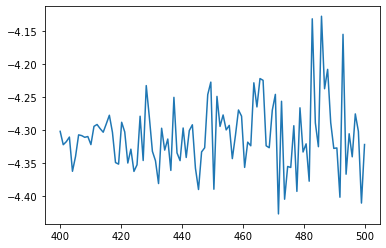

Smallest maximum norm: 3.734868583000542e-05
at epsilon =  471.7171717171717


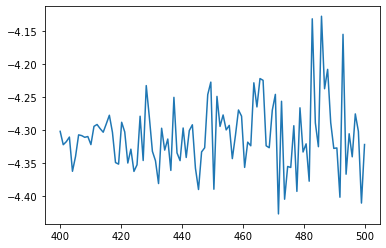

Smallest maximum norm: 5.5303578202572324e-05
at epsilon =  483.83838383838383


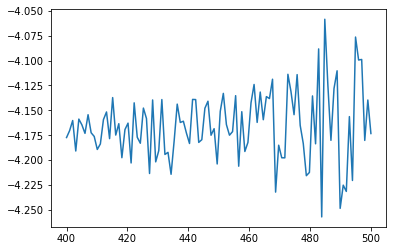

Smallest maximum norm: 5.5303578202572324e-05
at epsilon =  483.83838383838383


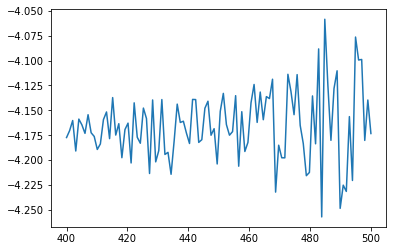

Smallest maximum norm: 4.551372706347618e-05
at epsilon =  403.030303030303


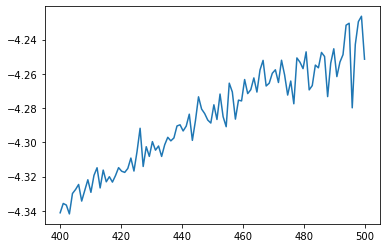

Smallest maximum norm: 4.551372706347618e-05
at epsilon =  403.030303030303


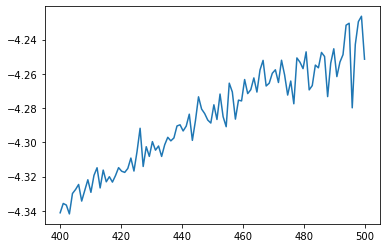

Smallest maximum norm: 2.2581486110552642e-05
at epsilon =  434.34343434343435


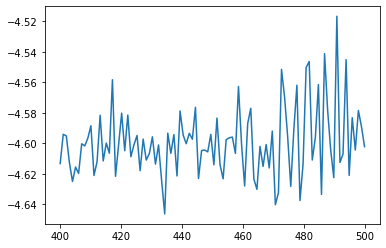

Smallest maximum norm: 2.2581486110552642e-05
at epsilon =  434.34343434343435


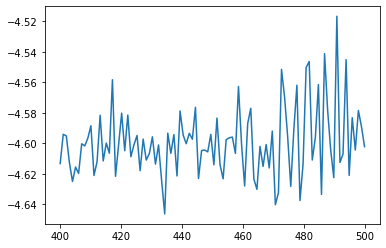

Smallest maximum norm: 2.9220915068463963e-05
at epsilon =  496.969696969697


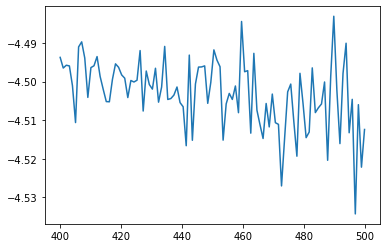

Smallest maximum norm: 2.9220915068463963e-05
at epsilon =  496.969696969697


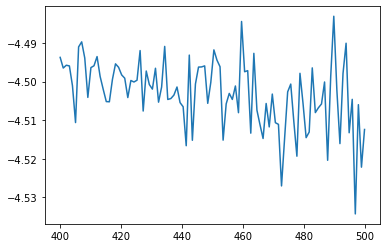

Smallest maximum norm: 4.2373975911653175e-05
at epsilon =  493.93939393939394


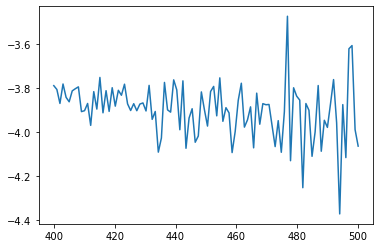

Smallest maximum norm: 4.2373975911653175e-05
at epsilon =  493.93939393939394


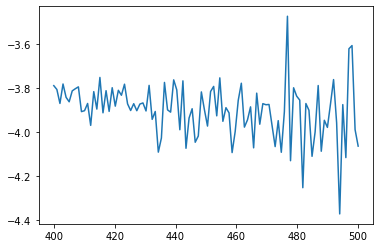

Smallest maximum norm: 3.5568659985397804e-05
at epsilon =  481.8181818181818


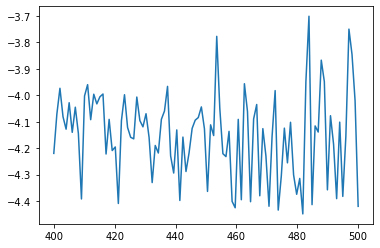

Smallest maximum norm: 3.5568659985397804e-05
at epsilon =  481.8181818181818


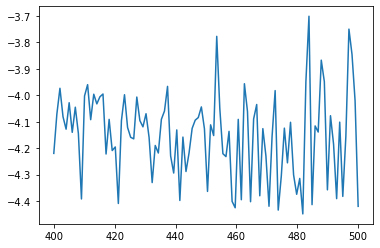

Smallest maximum norm: 0.0001356449539900339
at epsilon =  496.969696969697


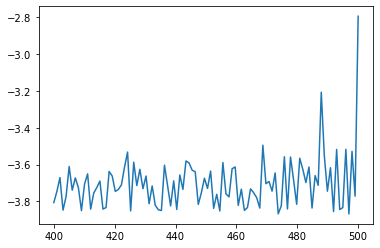

Smallest maximum norm: 0.0001356449539900339
at epsilon =  496.969696969697


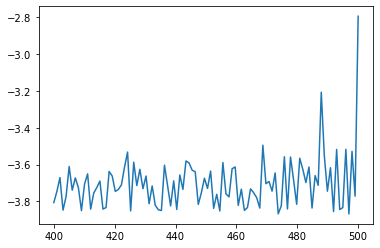

Smallest maximum norm: 0.0001265099380369209
at epsilon =  496.969696969697


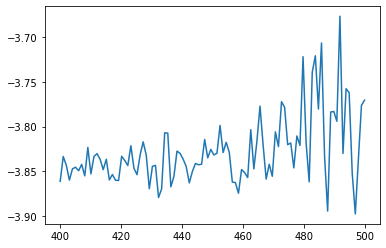

Smallest maximum norm: 0.0001265099380369209
at epsilon =  496.969696969697


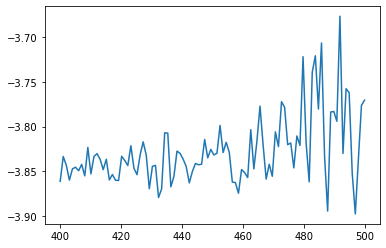

Smallest maximum norm: 0.00017065480361834617
at epsilon =  400.0


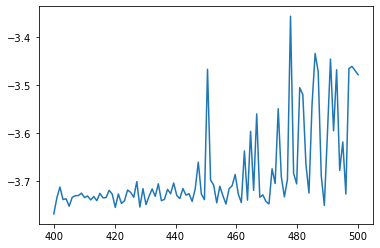

Smallest maximum norm: 0.00017065480361834617
at epsilon =  400.0


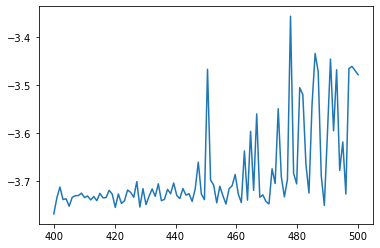

Smallest maximum norm: 0.00020593559372865362
at epsilon =  489.8989898989899


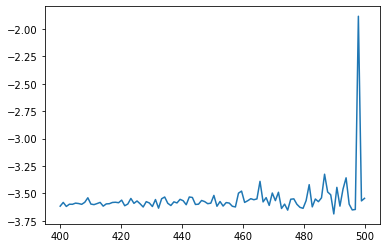

Smallest maximum norm: 0.00020593559372865362
at epsilon =  489.8989898989899


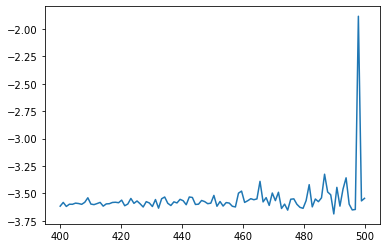

Smallest maximum norm: 0.00021408455429178897
at epsilon =  469.6969696969697


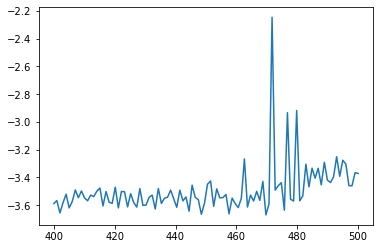

Smallest maximum norm: 0.00021408455429178897
at epsilon =  469.6969696969697


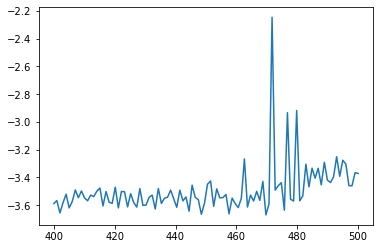

Smallest maximum norm: 5.104147872795641e-05
at epsilon =  431.3131313131313


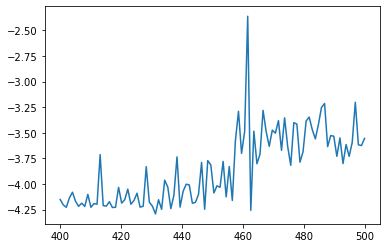

Smallest maximum norm: 5.104147872795641e-05
at epsilon =  431.3131313131313


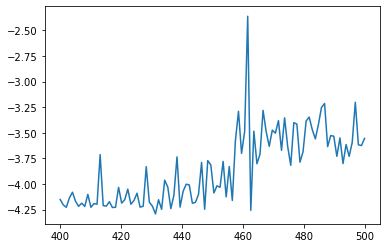

Smallest maximum norm: 3.1150843907176357e-05
at epsilon =  433.3333333333333


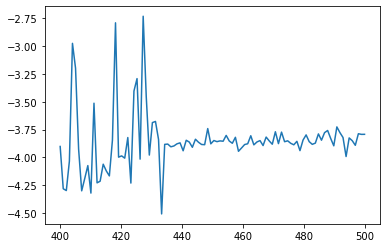

Smallest maximum norm: 3.1150843907176357e-05
at epsilon =  433.3333333333333


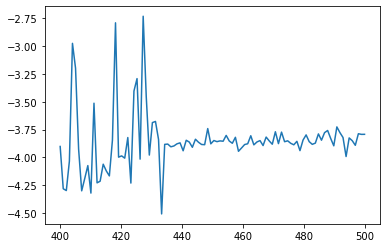

Smallest maximum norm: 0.0009202775084760556
at epsilon =  485.85858585858585


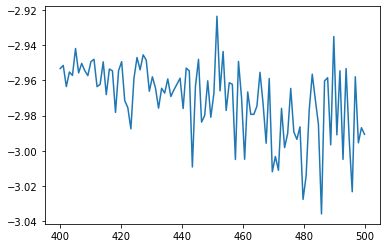

Smallest maximum norm: 0.0009202775084760556
at epsilon =  485.85858585858585


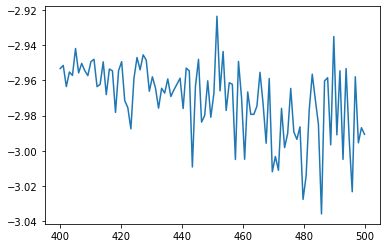

Smallest maximum norm: 4.4575017387969685e-05
at epsilon =  479.7979797979798


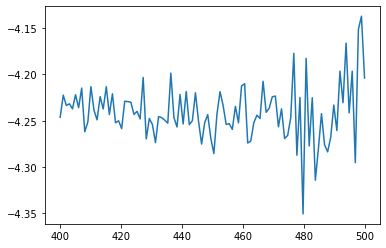

Smallest maximum norm: 4.4575017387969685e-05
at epsilon =  479.7979797979798


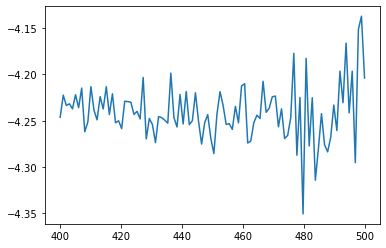

Smallest maximum norm: 0.00011540036060303884
at epsilon =  473.73737373737373


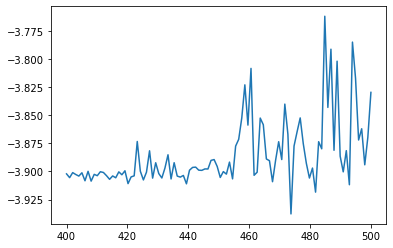

Smallest maximum norm: 0.00011540036060303884
at epsilon =  473.73737373737373


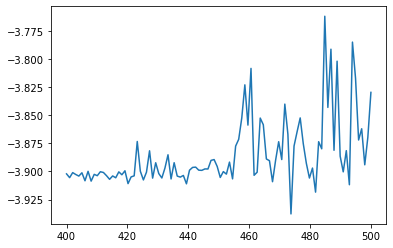

Smallest maximum norm: 2.256232754296379e-05
at epsilon =  463.6363636363636


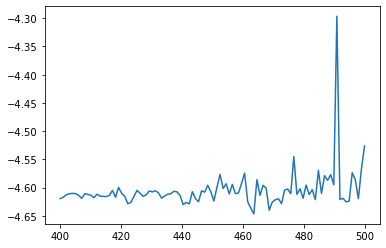

Smallest maximum norm: 2.256232754296379e-05
at epsilon =  463.6363636363636


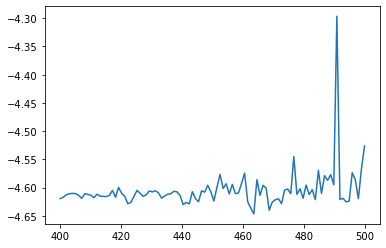

Smallest maximum norm: 3.6040972634266686e-05
at epsilon =  480.80808080808083


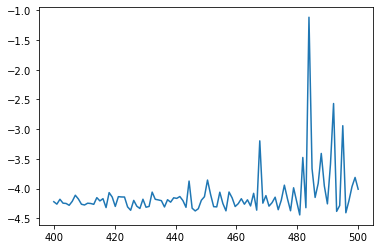

Smallest maximum norm: 3.6040972634266686e-05
at epsilon =  480.80808080808083


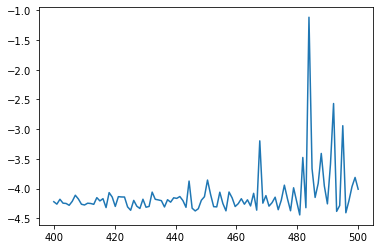

Smallest maximum norm: 7.106095044146182e-05
at epsilon =  481.8181818181818


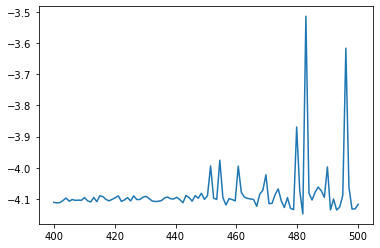

Smallest maximum norm: 7.106095044146182e-05
at epsilon =  481.8181818181818


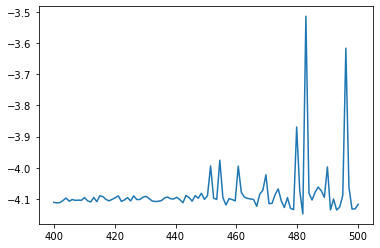

Smallest maximum norm: 1.4521425590544445e-05
at epsilon =  495.95959595959596


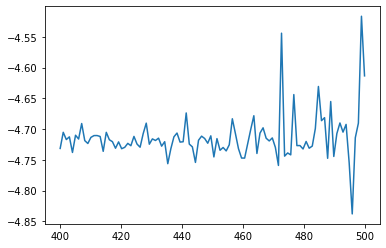

Smallest maximum norm: 1.4521425590544445e-05
at epsilon =  495.95959595959596


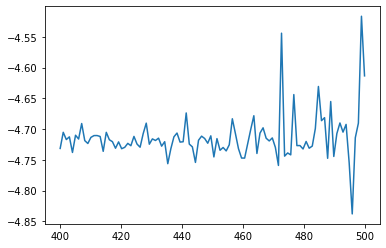

Smallest maximum norm: 4.117777552369701e-05
at epsilon =  484.8484848484849


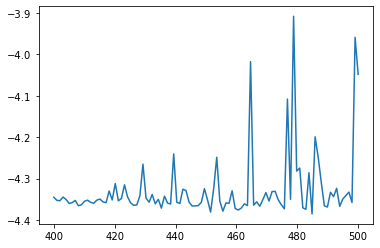

Smallest maximum norm: 4.117777552369701e-05
at epsilon =  484.8484848484849


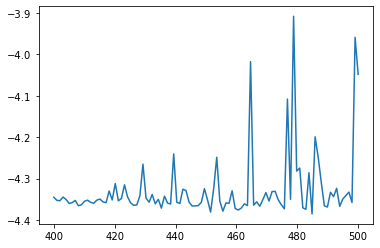

Smallest maximum norm: 5.48995714904131e-05
at epsilon =  475.75757575757575


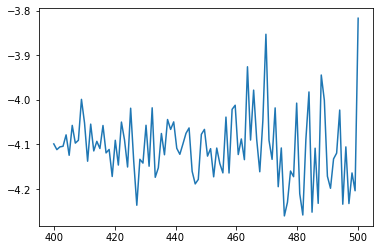

Smallest maximum norm: 5.48995714904131e-05
at epsilon =  475.75757575757575


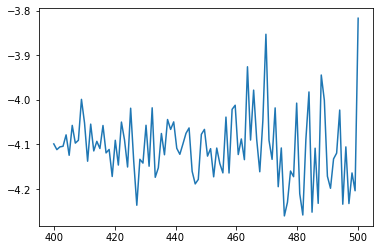

Smallest maximum norm: 4.8380839696469306e-05
at epsilon =  470.7070707070707


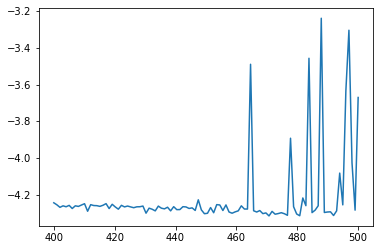

Smallest maximum norm: 4.8380839696469306e-05
at epsilon =  470.7070707070707


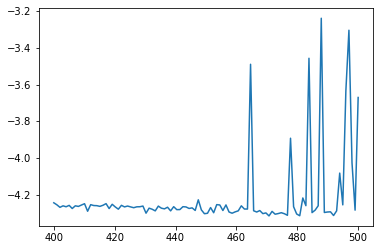

Smallest maximum norm: 2.9685905250933507e-05
at epsilon =  430.3030303030303


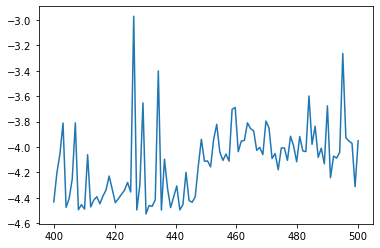

Smallest maximum norm: 2.9685905250933507e-05
at epsilon =  430.3030303030303


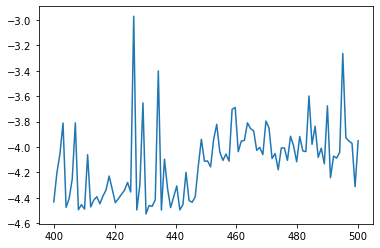

Smallest maximum norm: 1.6008427790695056e-05
at epsilon =  401.010101010101


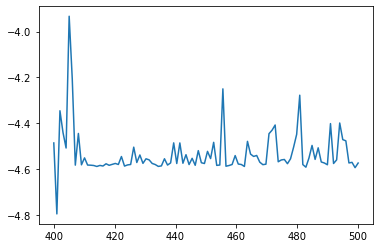

Smallest maximum norm: 1.6008427790695056e-05
at epsilon =  401.010101010101


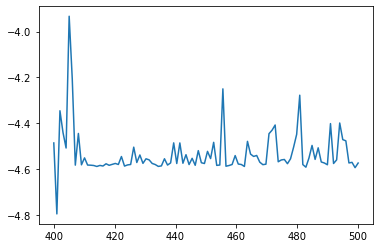

Smallest maximum norm: 1.8825862307394828e-05
at epsilon =  473.73737373737373


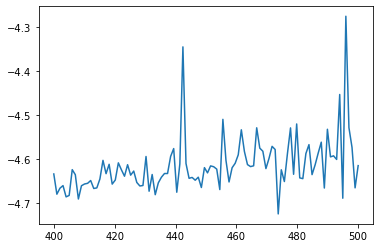

Smallest maximum norm: 1.8825862307394828e-05
at epsilon =  473.73737373737373


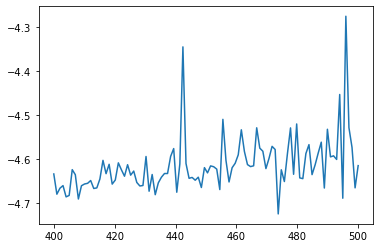

ModeResult(mode=array([400]), count=array([12]))


ValueError: operands could not be broadcast together with shapes (100,100) (2,1) 

In [347]:
import time
NTT = np.shape(reddata)[1]
qprior = np.eye(3,dtype=np.float64)
imat = np.eye(3,dtype=np.float64)
rvals = np.ones((3,NTT),dtype=np.float64)
# print(NTT-1)
ep_list=[]
minerr = []
start = time.time()
# print('0.0 %.\t Estimated time: ', end="")
for jj in range(NTT-1):
#     if jj == 10:
#         current = time.time() - start
#         total = current*(NTT-1-jj)/10
#         minutes = int(total/60)%60
#         hours = int(minutes/60)
#         seconds = int(total)%60
#         print('[',hours,':',minutes,':',seconds,']')
#     elif (jj/(NTT-1) * 100) == int(jj/(NTT-1) *100) and (jj/(NTT-1) * 100) != 0:
#         current = time.time() - start
#         if (jj/(NTT-1) * 100) == 1:
#             total = current*99
#         remaining = total - current
#         minutes = int(remaining/60)%60
#         hours = int(minutes/60)
#         seconds = int(remaining)%60
#         print(jj/(NTT-1) * 100, '%.\t Time remaining: [',hours,':',minutes,':',seconds,']')
        
    jacmatn = jacobian_maker(reddata, indices, dt, jj)
    jacmatp = jacobian_maker(reddata, indices, dt, jj+1)
    
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat-dt/2*jacmatp),(imat+dt/2*jacmatn)@qprior))
    rvals[:,jj] = np.diag(rnext)
    
# current = time.time() - start
# minutes = int(current/60)%60
# hours = int(minutes/60)
# seconds = int(current)%60
# print('100.0 %.\t Time elapsed: [',hours,':',minutes,':',seconds,']')
    
lvals = np.sum(np.log(np.abs(rvals)), 1)/tf

In [ ]:
print(lvals)

In [54]:
1/(2*0.0001)

5000.0

In [201]:
[  1.84767296  -0.30064716 -22.1086658 ]

[-20.56164]